# Supervised Model 2 - Neural Network
In this approach we train a neural network on encoded inputs of Ligand SMILES and Target Drug Sequence to try and predict the affinity between the two. It is a classic regression task where we are attempting to minimize the MSE between the predicted and actual values


## Prerequisites

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 15.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from rdkit import Chem
from rdkit.Chem import AllChem

## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/CS7641 Project/EC50_bind.tsv', sep='\t')
data.head()

,drug_id,target_id,smiles,target_seq,origin_affinity,affinity
0,100000,P49862,CN1CCN(Cc2c(O)c(Cl)cc3c(cc(=O)oc23)-c2ccccc2)CC1,MARSLLLPLQILLLSLALETAGEEAQGDKIIDGAPCARGSHPWQVA...,68293,4.165624
1,100001,P49862,COc1ccccc1C1CC(=Nc2nnnn12)c1ccc(C)cc1,MARSLLLPLQILLLSLALETAGEEAQGDKIIDGAPCARGSHPWQVA...,23546,4.628083
2,100002,P49862,Cc1oc2c(CN3CCCC3)c(O)ccc2c(=O)c1-c1ccc(Br)cc1,MARSLLLPLQILLLSLALETAGEEAQGDKIIDGAPCARGSHPWQVA...,>69498,4.158021
3,100003,P49862,CCN1C(c2ccccn2)n2c(nc3ccccc23)-c2ccccc12,MARSLLLPLQILLLSLALETAGEEAQGDKIIDGAPCARGSHPWQVA...,>69511,4.157940
4,100004,P49862,Oc1ccc2c(occ(-c3ccc(Br)cc3)c2=O)c1CN1CCOCC1,MARSLLLPLQILLLSLALETAGEEAQGDKIIDGAPCARGSHPWQVA...,66092,4.179851


In [ ]:
# Convert SMILES to fingerprints
def smiles_to_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    else:
        return np.zeros((n_bits,))

# Convert sequences to amino acid composition
def sequence_to_composition(sequence):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    composition = [sequence.count(aa) / len(sequence) for aa in amino_acids]
    return np.array(composition)

data['Fingerprint'] = data['smiles'].apply(smiles_to_fingerprint)
data['Composition'] = data['target_seq'].apply(sequence_to_composition)

Streaming output truncated to the last 5000 lines.
[01:44:51] DEPRECATION WARNING: please use MorganGenerator
[01:44:51] DEPRECATION WARNING: please use MorganGenerator
[01:44:51] DEPRECATION WARNING: please use MorganGenerator
[01:44:51] DEPRECATION WARNING: please use MorganGenerator
[01:44:51] DEPRECATION WARNING: please use MorganGenerator
[01:44:51] DEPRECATION WARNING: please use MorganGenerator
[01:44:51] DEPRECATION WARNING: please use MorganGenerator
[01:44:51] DEPRECATION WARNING: please use MorganGenerator
[01:44:51] DEPRECATION WARNING: please use MorganGenerator
[01:44:51] DEPRECATION WARNING: please use MorganGenerator
[01:44:51] DEPRECATION WARNING: please use MorganGenerator
[01:44:51] DEPRECATION WARNING: please use MorganGenerator
[01:44:51] DEPRECATION WARNING: please use MorganGenerator
[01:44:51] DEPRECATION WARNING: please use MorganGenerator
[01:44:51] DEPRECATION WARNING: please use MorganGenerator
[01:44:51] DEPRECATION WARNING: please use MorganGenerator
[01:4

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
X_drug = [torch.tensor(fp, dtype=torch.float32).to(device) for fp in data['Fingerprint']]
X_target = [torch.tensor(comp, dtype=torch.float32).to(device) for comp in data['Composition']]

flattened_drugs = torch.stack([torch.tensor(fp, dtype=torch.float32) for fp in X_drug])
flattened_targets = torch.stack([torch.tensor(comp, dtype=torch.float32) for comp in X_target])

combined_features = torch.cat((flattened_drugs, flattened_targets), dim=1)

<ipython-input-7-14b46d1573dd>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  flattened_drugs = torch.stack([torch.tensor(fp, dtype=torch.float32) for fp in X_drug])
<ipython-input-7-14b46d1573dd>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  flattened_targets = torch.stack([torch.tensor(comp, dtype=torch.float32) for comp in X_target])


Cumulative explained variance by the first 1000 PCs: 0.9045271988843417


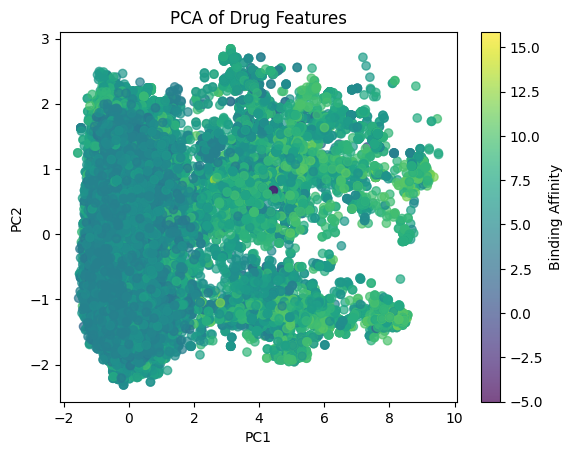

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)   # Adjust the number of components as needed
pca_drug_features = pca.fit_transform(flattened_drugs.cpu().numpy())

explained_variance = pca.explained_variance_ratio_
total_explained_variance = np.sum(explained_variance)
# print(f"Explained variance by 1000 PCs: {explained_variance}")
print(f"Cumulative explained variance by the first 1000 PCs: {total_explained_variance}")

# Visualize the PCA results
import matplotlib.pyplot as plt
plt.scatter(pca_drug_features[:, 0], pca_drug_features[:, 1], c=data['affinity'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Binding Affinity')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Drug Features')
plt.show()

Explained variance by 15 PCs: [0.32167593 0.20443615 0.07833151 0.07266549 0.05221728 0.04094927
 0.03398836 0.03230896 0.02696732 0.02427135 0.01967389 0.01723707
 0.01548456 0.01451318 0.01180882]
Cumulative explained variance by the first 15 PCs: 0.9665291905403137


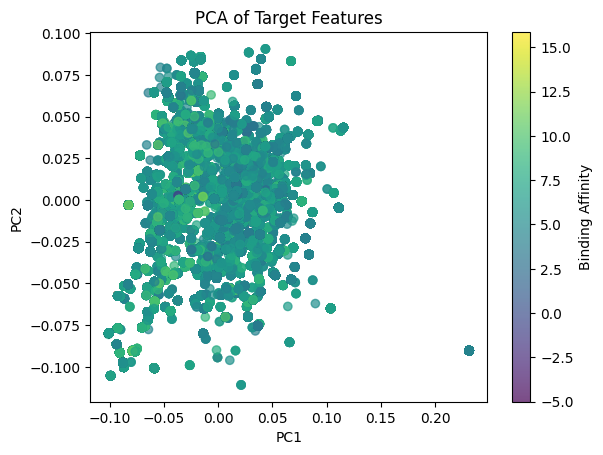

In [ ]:
pca_target = PCA(n_components=15)   # Adjust the number of components as needed
pca_target_features = pca_target.fit_transform(flattened_targets.cpu().numpy())

explained_variance_target = pca_target.explained_variance_ratio_
total_explained_variance_target = np.sum(explained_variance_target)
print(f"Explained variance by 15 PCs: {explained_variance_target}")
print(f"Cumulative explained variance by the first 15 PCs: {total_explained_variance_target}")

# Visualize the PCA results
import matplotlib.pyplot as plt
plt.scatter(pca_target_features[:, 0], pca_target_features[:, 1], c=data['affinity'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Binding Affinity')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Target Features')
plt.show()

In [ ]:
X_drug_pca = torch.tensor(pca_drug_features, dtype=torch.float32).to(device)
X_target_pca = torch.tensor(pca_target_features, dtype=torch.float32).to(device)

In [ ]:
X = [(drug, target) for drug, target in zip(X_drug_pca, X_target_pca)]
y = torch.tensor(data['affinity'].values, dtype=torch.float32).to(device)

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

class AffinityDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def collate_fn(batch):
    drugs = [item[0][0] for item in batch]
    targets = [item[0][1] for item in batch]
    affinities = torch.tensor([item[1] for item in batch], dtype=torch.float32).to(device)

    return drugs, targets, affinities

dataset = AffinityDataset(X, y)
test_split_ratio = 0.2
test_size = int(len(dataset) * test_split_ratio)
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32

dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

## Model Initialization

In [ ]:
import torch.nn as nn

class AffinityNN(nn.Module):
    def __init__(self):
        super(AffinityNN, self).__init__()
        self.drug_fc = nn.Sequential(
            nn.Linear(1000, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.target_fc = nn.Sequential(
            nn.Linear(15, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.fc_combined = nn.Sequential(
            nn.Linear(128 + 64, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, drugs, targets):
        drug_out = torch.stack([self.drug_fc(drug) for drug in drugs]).to(device)
        target_out = torch.stack([self.target_fc(target) for target in targets]).to(device)
        combined = torch.cat((drug_out, target_out), dim=1)
        output = self.fc_combined(combined)
        return output

In [ ]:
model = AffinityNN()
device = torch.device("cuda")
model.to(device)

AffinityNN(
  (drug_fc): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (target_fc): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc_combined): Sequential(
    (0): Linear(in_features=192, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(initialize_weights)

AffinityNN(
  (drug_fc): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (target_fc): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc_combined): Sequential(
    (0): Linear(in_features=192, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

# Training and Evaluation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

best_model_pca_path = "best_model_pca.pth"

best_loss = float("inf")

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for drugs, targets, affinities in dataloader:
        drugs = [drug.to(device) for drug in drugs]
        targets = [target.to(device) for target in targets]
        affinities = affinities.to(device)

        optimizer.zero_grad()

        outputs = model(drugs, targets)

        outputs = outputs.view(-1, 1)
        affinities = affinities.view(-1, 1)

        loss = criterion(outputs, affinities)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        print(f"New best loss: {avg_loss:.4f}. Saving model...")
        best_loss = avg_loss
        torch.save(model.state_dict(), best_model_pca_path)

print("Loading the best model...")
model.load_state_dict(torch.load(best_model_pca_path))
model.eval()

Epoch 1/20, Loss: 4.5415
New best loss: 4.5415. Saving model...
Epoch 2/20, Loss: 2.1058
New best loss: 2.1058. Saving model...
Epoch 3/20, Loss: 1.9391
New best loss: 1.9391. Saving model...
Epoch 4/20, Loss: 1.8198
New best loss: 1.8198. Saving model...
Epoch 5/20, Loss: 1.7282
New best loss: 1.7282. Saving model...
Epoch 6/20, Loss: 1.6475
New best loss: 1.6475. Saving model...
Epoch 7/20, Loss: 1.5634
New best loss: 1.5634. Saving model...
Epoch 8/20, Loss: 1.5029
New best loss: 1.5029. Saving model...
Epoch 9/20, Loss: 1.4469
New best loss: 1.4469. Saving model...
Epoch 10/20, Loss: 1.3970
New best loss: 1.3970. Saving model...
Epoch 11/20, Loss: 1.3411
New best loss: 1.3411. Saving model...
Epoch 12/20, Loss: 1.3030
New best loss: 1.3030. Saving model...
Epoch 13/20, Loss: 1.2597
New best loss: 1.2597. Saving model...
Epoch 14/20, Loss: 1.2316
New best loss: 1.2316. Saving model...
Epoch 15/20, Loss: 1.1964
New best loss: 1.1964. Saving model...
Epoch 16/20, Loss: 1.1703
New best

<ipython-input-22-5331d2b4aca9>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_pca_path))


AffinityNN(
  (drug_fc): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (target_fc): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc_combined): Sequential(
    (0): Linear(in_features=192, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
from google.colab import files
files.download('best_model_pca.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
best_model_path = "best_model_pca.pth"
model.load_state_dict(torch.load(best_model_path))

<ipython-input-24-d8dbfb40b911>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [ ]:
model.eval()
test_loss = 0.0

with torch.no_grad():
    for drugs, targets, affinities in test_dataloader:
        predictions = model(drugs, targets)
        loss = criterion(predictions.view(-1), affinities)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_dataloader)}")

Test Loss: 0.9633970576978754


# Inference

In [ ]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for drugs, targets, affinities in dataloader:
    drugs = [drug.to(device) for drug in drugs]
    targets = [target.to(device) for target in targets]
    affinities = affinities.to(device)

    with torch.no_grad():
        predictions = model(drugs, targets)

    predictions = predictions.view(-1).cpu().numpy()

    print(f"Predicted Affinities (Batch of {batch_size}):")
    print(predictions)

    true_affinities = affinities.cpu().numpy()
    print(f"True Affinities (Batch of {batch_size}):")
    print(true_affinities)

    break

Predicted Affinities (Batch of 32):
[7.422458  6.3869123 6.999467  5.4398465 6.957203  5.558583  6.4144998
 7.4545445 5.770544  5.6675606 6.411882  6.1106396 6.624708  5.881838
 6.0939484 7.562309  6.1775975 5.3876553 7.9124103 4.29012   7.7562766
 6.2928576 8.825178  4.2417927 4.558385  5.5552063 4.988442  4.4829054
 5.9553614 6.2857485 8.152275  7.506413 ]
True Affinities (Batch of 32):
[ 7.5228786  7.3882766  7.8860564  6.5850267  7.221849   6.3018994
  7.5228786  7.2596374  6.0457573  5.124939   5.79588    5.999566
  7.7447276  6.2596374  5.838632   6.6575775  5.8999743  6.5086384
  8.259637   3.6434007  8.30103    6.79588   10.444905   3.5228772
  5.381952   5.6819367  4.004365   4.170304   7.1487417  4.5000105
  7.1001797  7.1366773]


<ipython-input-26-afb6d0e32141>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
